MoA: Pytorch-RankGauss-PCA-NN upgrade & 3D visual との差分を※で説明する


# ①データ、ライブラリ読み込み
---



In [ ]:
# Gドライブをマウント
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#データの読み込み
import pandas as pd

train_features_original = pd.read_csv('gdrive/My Drive/train_features.csv')
train_drug_original = pd.read_csv('gdrive/My Drive/train_drug.csv')
train_targets_original = pd.read_csv('gdrive/My Drive/train_targets_scored.csv')
train_targets_nonscored_original = pd.read_csv('gdrive/My Drive/train_targets_nonscored.csv')
test_features_original = pd.read_csv('gdrive/My Drive/test_features.csv')
columns_original = pd.read_csv('gdrive/My Drive/train_targets_scored.csv')
sample_original = pd.read_csv('gdrive/My Drive/sample_submission.csv')

In [ ]:
#データコピー
train_features = train_features_original.copy()
train_targets_scored = train_targets_original.copy()
train_targets_nonscored = train_targets_nonscored_original.copy()
test_features = test_features_original.copy()
sample_submission = sample_original.copy()

#ライブラリインポート
!pip install iterative-stratification
!pip install japanize_matplotlib
!pip install imbalanced-learn==0.7.0
import japanize_matplotlib
import numpy as np
import random
import pandas as pd
import os
import copy
import gc


import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import scipy.stats as stats
from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import _WeightedLoss

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 2000)

In [ ]:
train_features2=train_features.copy()
test_features2=test_features.copy()

In [ ]:
#パラメータの指定
n_comp_GENES = 600 #※463
n_comp_CELLS = 50 #※60
VarianceThreshold_for_FS = 0.85
Dropout_Model = 0.25
print('n_comp_GENES', n_comp_GENES, 'n_comp_CELLS', n_comp_CELLS, 'total', n_comp_GENES + n_comp_CELLS)

n_comp_GENES 600 n_comp_CELLS 50 total 650


# ②RankGauss処理を実施

In [ ]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [ ]:
# RankGauss - transform to Gauss
for col in (GENES + CELLS):
    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")   # from optimal commit 9
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

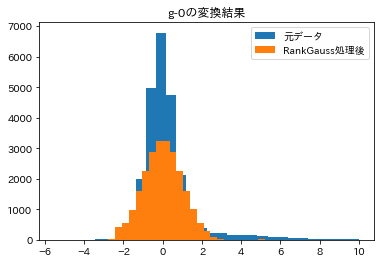

In [ ]:
#結果の確認
plt.hist(train_features_original['g-0'],bins=30,label='元データ')
plt.hist(train_features['g-0'],bins=30,label='RankGauss処理後')
plt.title('g-0の変換結果')
plt.legend()
plt.show()

In [ ]:
#Seedの設定
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# ③PCAの実施

In [ ]:
n_comp = 600  #<--Update
pca_g = PCA(n_components=n_comp, random_state=42)
data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
gpca= (pca_g.fit(data[GENES]))
train2= (gpca.transform(train_features[GENES]))
test2 = (gpca.transform(test_features[GENES]))

train_gpca = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test_gpca = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train_gpca), axis=1)
test_features = pd.concat((test_features, test_gpca), axis=1)


In [ ]:
#CELLS
n_comp = 50  #<--Update

pca_c = PCA(n_components=n_comp, random_state=42)
data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
cpca= (pca_c.fit(data[CELLS]))
train2= (cpca.transform(train_features[CELLS]))
test2 = (cpca.transform(test_features[CELLS]))

train_cpca = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test_cpca = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train_cpca), axis=1)
test_features = pd.concat((test_features, test_cpca), axis=1)

# ④変数選択

In [ ]:
data = train_features.append(test_features)
data

sig_id cp_type  cp_time cp_dose       g-0       g-1       g-2  \
0     id_000644bb2  trt_cp       24      D1  1.134849  0.907687 -0.416385   
1     id_000779bfc  trt_cp       72      D1  0.119282  0.681738  0.272399   
2     id_000a6266a  trt_cp       48      D1  0.779973  0.946463  1.425350   
3     id_0015fd391  trt_cp       48      D1 -0.734910 -0.274641 -0.438509   
4     id_001626bd3  trt_cp       72      D2 -0.452718 -0.477513  0.972316   
...            ...     ...      ...     ...       ...       ...       ...   
3977  id_ff7004b87  trt_cp       24      D1  0.599272 -0.691298  2.335275   
3978  id_ff925dd0d  trt_cp       24      D1 -0.844395 -0.282043  2.006827   
3979  id_ffb710450  trt_cp       72      D1 -0.563702 -0.146343  0.232721   
3980  id_ffbb869f2  trt_cp       48      D2 -1.591078 -1.924736 -0.619409   
3981  id_ffd5800b6  trt_cp       72      D1 -0.740040  0.509977  0.308699   

           g-3       g-4       g-5       g-6       g-7       g-8       g-9  \
0    -0.966814 -0.254723 -1.017473 -1.364787 -0.024007  0.679466 -0.311014   
1     0.080113  1.205169  0.686517  0.313396  0.555877 -0.538257  0.837592   
2    -0.132928 -0.006122  1.492493  0.235577  0.365511 -0.006556  1.238615   
3     0.759097  2.346330 -0.858153 -2.288417  0.309275 -0.192409 -1.383015   
4     0.970731  1.463427 -0.869555 -0.375501 -0.205867 -1.064171  0.850357   
...        ...       ...       ...       ...       ...       ...       ...   
3977 -0.965903  1.073011  1.784340  0.093554 -0.776934 -1.298359  0.709442   
3978  0.507512  0.643034  0.434686 -1.006733  0.004563  0.316542  1.882578   
3979 -1.052568  0.066341  0.635259 -0.019701  1.182399  0.028286  1.395853   
3980  1.321092 -1.622643 -0.263479 -0.487639 -1.282347  1.176142  0.647849   
3981 -0.080621 -0.080190  1.096267 -1.176207  0.635413 -0.078347  0.241467   

          g-10      g-11      g-12      g-13      g-14      g-15      g-16  \
0     1.526019  0.171308  0.621302 -0.560444  0.281356 -1.058992 -1.139669   
1    -1.246895 -0.576216 -0.210328  0.545961  0.148988  0.393359  0.398284   
2    -0.641087 -0.771401 -0.128997 -2.316078  0.879141 -0.546448  0.470107   
3    -1.000646 -0.495448 -1.143743 -0.817040 -1.763535  1.392512 -0.229131   
4    -0.336503 -0.703793 -1.245821  1.182072  0.318154  0.343533 -0.026074   
...        ...       ...       ...       ...       ...       ...       ...   
3977  0.324174  0.953620  0.848090 -0.960789 -0.802903 -1.728089 -0.024130   
3978  0.222345  0.469220  0.942400 -1.363980  0.275272  2.247390  1.309819   
3979  0.578407 -0.586527 -0.242674 -0.387189  0.647801 -1.258820 -0.401122   
3980  1.858832  0.778095  1.242258  1.312632  1.390780  0.822951 -0.387074   
3981  0.271138  0.288358 -0.275218  1.369417 -0.649133  1.316011  0.495280   

          g-17      g-18      g-19      g-20      g-21      g-22      g-23  \
0     0.870454  0.379613 -0.511557 -0.723914 -1.330500 -1.676873  1.244529   
1     0.397419 -0.838965  0.499417  1.226498 -0.136304 -0.396829 -0.444660   
2    -0.406391 -0.308666 -0.043430 -0.106817 -1.012321 -1.944864  0.532973   
3    -1.052197  0.244593 -2.122611  2.082587 -1.352449 -1.101286 -1.063392   
4    -1.565613 -0.849160 -0.705024 -0.447355 -0.292812  1.053214  0.491212   
...        ...       ...       ...       ...       ...       ...       ...   
3977  0.382447  0.791450 -1.420263  1.279532 -0.954103  0.967503  1.507857   
3978 -0.248054  0.755963  0.886138  0.838045 -0.930441 -0.251178  0.714776   
3979  1.313802  0.958729 -1.226396 -1.343141 -0.165330 -0.312633  0.714776   
3980  0.709174  0.030438 -0.122322  1.220628 -1.790665  0.328432 -1.036980   
3981  0.586615 -1.151153 -1.858989  0.043624  0.464719 -1.264967  0.114185   

          g-24      g-25      g-26      g-27      g-28      g-29      g-30  \
0     0.560983  0.401883  0.240395  0.165332 -0.520720  0.773151  0.415307   
1     0.396746 -0.582440  0.633148  0.220342 -0.744141 -0.187325 -0.121009   
2     0.626072  0.698526 -1.378719  2.3919

In [ ]:
#分散が0.9以下の変数を削除する
var_thresh = VarianceThreshold(VarianceThreshold_for_FS)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

In [ ]:
#削除された変数を確認
remove_column_list=data.columns[4:][np.logical_not(var_thresh.get_support())]
remove_column_list

Index(['pca_G-143', 'pca_G-144', 'pca_G-145', 'pca_G-146', 'pca_G-147',
       'pca_G-148', 'pca_G-149', 'pca_G-150', 'pca_G-151', 'pca_G-152',
       ...
       'pca_C-40', 'pca_C-41', 'pca_C-42', 'pca_C-43', 'pca_C-44', 'pca_C-45',
       'pca_C-46', 'pca_C-47', 'pca_C-48', 'pca_C-49'],
      dtype='object', length=500)

In [ ]:
#削除された説明変数の分散を確認
data[remove_column_list].var().max()

0.8493574107142264

In [ ]:
#削除した結果をデータフレームに格納
train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]

train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)

test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])
test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)
train_features.head()

sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_000644bb2  trt_cp      24      D1  1.134849  0.907687 -0.416385   
1  id_000779bfc  trt_cp      72      D1  0.119282  0.681738  0.272399   
2  id_000a6266a  trt_cp      48      D1  0.779973  0.946463  1.425350   
3  id_0015fd391  trt_cp      48      D1 -0.734910 -0.274641 -0.438509   
4  id_001626bd3  trt_cp      72      D2 -0.452718 -0.477513  0.972316   

          3         4         5         6         7         8         9  \
0 -0.966814 -0.254723 -1.017473 -1.364787 -0.024007  0.679466 -0.311014   
1  0.080113  1.205169  0.686517  0.313396  0.555877 -0.538257  0.837592   
2 -0.132928 -0.006122  1.492493  0.235577  0.365511 -0.006556  1.238615   
3  0.759097  2.346330 -0.858153 -2.288417  0.309275 -0.192409 -1.383015   
4  0.970731  1.463427 -0.869555 -0.375501 -0.205867 -1.064171  0.850357   

         10        11        12        13        14        15        16  \
0  1.526019  0.171308  0.621302 -0.560444  0.281356 -1.058992 -1.139669   
1 -1.246895 -0.576216 -0.210328  0.545961  0.148988  0.393359  0.398284   
2 -0.641087 -0.771401 -0.128997 -2.316078  0.879141 -0.546448  0.470107   
3 -1.000646 -0.495448 -1.143743 -0.817040 -1.763535  1.392512 -0.229131   
4 -0.336503 -0.703793 -1.245821  1.182072  0.318154  0.343533 -0.026074   

         17        18        19        20        21        22        23  \
0  0.870454  0.379613 -0.511557 -0.723914 -1.330500 -1.676873  1.244529   
1  0.397419 -0.838965  0.499417  1.226498 -0.136304 -0.396829 -0.444660   
2 -0.406391 -0.308666 -0.043430 -0.106817 -1.012321 -1.944864  0.532973   
3 -1.052197  0.244593 -2.122611  2.082587 -1.352449 -1.101286 -1.063392   
4 -1.565613 -0.849160 -0.705024 -0.447355 -0.292812  1.053214  0.491212   

         24        25        26        27        28        29        30  \
0  0.560983  0.401883  0.240395  0.165332 -0.520720  0.773151  0.415307   
1  0.396746 -0.582440  0.633148  0.220342 -0.744141 -0.187325 -0.121009   
2  0.626072  0.698526 -1.378719  2.391957 -0.094196  1.580764 -1.458665   
3 -1.422739  0.002243 -1.052410  0.263509 -0.456821 -1.246761 -0.975328   
4  1.686065  1.003204  1.071737 -0.553237 -1.541559  0.377022 -0.154071   

         31        32        33        34        35        36        37  \
0 -1.103744 -0.052653 -0.442339 -0.199741  0.273999  0.384531 -0.584221   
1 -0.552709  1.658538 -0.370436  0.352198 -0.284901  0.202415  0.782016   
2  0.812531  0.737065  0.205563 -0.001697 -1.669590  0.147467 -0.155573   
3  0.124462 -2.086299  1.037352  0.779250 -2.137027 -1.410252 -1.056203   
4  0.842675  1.135803 -0.138784  1.488381 -1.024337 -1.319991  1.634813   

         38        39        40        41        42        43        44  \
0 -0.740294 -0.370812 -0.010335 -0.344428 -1.358528  0.422445 -1.256603   
1 -0.357596 -0.090577  0.207541 -0.524043 -1.341775  0.616029  1.867273   
2  1.704209  1.307218  0.545733 -0.722011  0.099634 -0.534049 -0.576743   
3  1.413863 -0.641700 -0.886370 -0.004318  0.247273 -2.032801 -0.924678   
4  0.772677 -0.154153  0.223176  0.167132  1.427355  0.278502  0.845635   

         45        46        47        48        49        50        51  \
0  0.330490 -0.348463 -0.021220  0.060618  0.698772 -0.180961 -0.660466   
1  1.336128  0.558413 -0.500773  0.235031 -1.095092  1.791187 -0.674459   
2 -0.783407  0.244490 -1.054991 -0.666826  0.741658 -0.148515 -0.350200   
3 -0.993542 -0.416878  0.124110 -0.647089  1.022892 -1.318590 -0.811620   
4  1.391405  1.478760 -1.272159 -0.495301 -0.997777 -0.125053 -0.510774   

         52        53        54        55        56        57        58  \
0  0.841871  0.567061 -0.152171 -0.229101 -0.768620  0.277483  0.798624   
1 -0.348406 -1.002545 -0.773191 -0.173552 -0.732006  0.580699  0.438223   
2  0.833196  0.321971 -1.084313 -0.603636  1.367787  0.059907 -0.259505   
3 -1.426839  1.707077 -0.932919 -1.355884 -0.691715  0.529781  0.091499   
4  0.948958 -0.027765  0.150221  1.651

# (※) K-Meansを実施

In [ ]:
#g-に関してK-Meansでクラスターを作成
#クラスターについてダミー変数化
from sklearn.cluster import KMeans
def fe_cluster_genes(train, test, n_clusters_g = 22, SEED = 42):
    
    features_g = GENES
    #features_c = CELLS
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans_genes = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        
        train[f'clusters_{kind}'] = kmeans_genes.predict(train_.values)
        test[f'clusters_{kind}'] = kmeans_genes.predict(test_.values)
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
   # train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features2 ,test_features2=fe_cluster_genes(train_features2,test_features2)

In [ ]:
train_features2.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360   
1  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646   
2 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181   
3 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580   
4  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934   
1 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499   
2 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530   
3 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575   
4  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
1 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
2  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
3  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
4  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350   
1  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710   
2  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983   
3 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851   
4  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263   
1 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759   
2  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621   
3  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331   
4 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670   
1  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026   
2 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292   
3  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314   
4  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332   
1  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857   
2  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570   
3  

In [ ]:
#c-に関してK-Meansでクラスターを作成
#クラスターについてダミー変数化
def fe_cluster_cells(train, test, n_clusters_c = 4, SEED = 42):
    
    #features_g = GENES
    features_c = CELLS
    
    def create_cluster(train, test, features, kind = 'c', n_clusters = n_clusters_c):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans_cells = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        
        train[f'clusters_{kind}'] = kmeans_cells.predict(train_.values)
        test[f'clusters_{kind}'] = kmeans_cells.predict(test_.values)
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
   # train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features2 ,test_features2=fe_cluster_cells(train_features2,test_features2)

In [ ]:
train_features2.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360   
1  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646   
2 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181   
3 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580   
4  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934   
1 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499   
2 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530   
3 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575   
4  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
1 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
2  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
3  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
4  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350   
1  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710   
2  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983   
3 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851   
4  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263   
1 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759   
2  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621   
3  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331   
4 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670   
1  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026   
2 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292   
3  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314   
4  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332   
1  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857   
2  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570   
3  

In [ ]:
train_pca=pd.concat((train_gpca,train_cpca),axis=1)
test_pca=pd.concat((test_gpca,test_cpca),axis=1)
train_pca.head()

pca_G-0   pca_G-1    pca_G-2   pca_G-3   pca_G-4   pca_G-5   pca_G-6  \
0  -5.503029  3.906768   9.351159 -7.887679  4.824083  0.811314  3.449602   
1  -4.877068  3.920620 -11.350171  5.757735  0.920613  0.266473  1.019473   
2   1.253932 -7.228903  -5.444888 -0.799425  0.925822  3.691425 -1.875771   
3  11.471601 -8.716818  -4.270875 -5.753081 -7.016178 -2.663915 -2.212708   
4  -6.567311 -2.329058 -10.739698 -4.195690 -8.082751 -8.178735 -4.287316   

    pca_G-7   pca_G-8   pca_G-9  pca_G-10  pca_G-11  pca_G-12  pca_G-13  \
0  1.623902  0.908790  2.106824 -0.767113  1.603392  2.341614  0.156929   
1 -0.386415  5.384124  1.449265  0.526481 -0.712841 -0.490508 -0.807035   
2  2.621309 -4.671833  0.979130 -0.637435  0.348702  2.086509 -1.480031   
3  6.528489 -2.616297 -3.532113  3.874946 -3.343612 -4.256670  0.628273   
4 -3.163365 -1.683828  0.856960  3.010228 -2.245641 -1.826105  3.395008   

   pca_G-14  pca_G-15  pca_G-16  pca_G-17  pca_G-18  pca_G-19  pca_G-20  \
0  1.387997 -0.599206  0.219463  0.157297  1.300083 -0.231696  0.653935   
1 -0.137103  1.131055 -2.376870 -0.394900 -0.446405 -0.743034  1.431268   
2  1.071902  0.326394 -1.927129 -1.490003  1.122704  1.770434 -2.294632   
3  0.189944 -0.434614  0.465455 -0.551063 -1.096546  2.884942 -2.593319   
4 -4.540560 -1.943278 -0.332442  0.603162  2.907792  1.583969 -0.692863   

   pca_G-21  pca_G-22  pca_G-23  pca_G-24  pca_G-25  pca_G-26  pca_G-27  \
0 -1.753501 -0.178203  0.012717 -1.499515  1.789295  0.964395 -0.645070   
1  1.607115 -2.050150 -0.162719 -2.317117 -2.217002  0.866609 -0.315090   
2 -1.008747  1.851630 -1.900571 -0.221281 -1.337006 -1.335874 -1.370667   
3 -0.501421  0.110557 -0.953081 -2.238143 -1.424792  0.723566 -1.259287   
4 -0.410479  0.708917 -1.610561 -1.171560 -3.474255  0.453548  0.906361   

   pca_G-28  pca_G-29  pca_G-30  pca_G-31  pca_G-32  pca_G-33  pca_G-34  \
0 -0.884456 -0.504399 -0.879262 -0.265221 -0.240747 -1.628311 -0.201253   
1  0.627999  1.046059 -2.476701  0.035907  1.761616 -1.534911  2.614654   
2 -1.130541 -0.363277 -0.825964 -3.219788 -0.420406  1.217911 -1.832015   
3 -1.736424  1.228399 -3.177110  2.654832 -2.238496 -1.804598  1.265728   
4  0.872246  0.798886 -0.196198  1.476154  0.850195 -1.252324  3.392127   

   pca_G-35  pca_G-36  pca_G-37  pca_G-38  pca_G-39  pca_G-40  pca_G-41  \
0 -0.578994  1.719793 -0.257566  1.707819  0.068221  0.467228 -0.338598   
1  0.155226 -1.194066  1.594071  0.308537  1.683269 -0.481463 -0.667850   
2  2.470818 -1.457892 -3.273068  2.252985 -0.321513  2.311948  2.073200   
3 -1.202478 -2.230749 -5.543533 -4.432533 -0.171230  0.445814  0.652195   
4 -1.265831  0.402682  0.712911 -3.015220 -0.160086 -0.323824 -2.037852   

   pca_G-42  pca_G-43  pca_G-44  pca_G-45  pca_G-46  pca_G-47  pca_G-48  \
0  0.622010  2.072037 -1.284736 -0.551198 -0.368320  0.698693  1.218162   
1  0.445548 -1.027908  0.886348 -0.846880 -1.025121  0.217296  0.779725   
2 -1.725404 -0.500124  0.456827  0.153661  2.648530 -0.115129  2.064633   
3  0.629968  2.534817  0.387681  1.101987 -1.200746  1.213676  0.024793   
4 -0.973484  0.222855  1.068100  1.212946  0.287245  1.225697 -1.703716   

   pca_G-49  pca_G-50  pca_G-51  pca_G-52  pca_G-53  pca_G-54  pca_G-55  \
0  0.029452  0.894843  0.533300 -0.576915 -1.276710  0.886851  0.020306   
1  0.887492  0.229361  1.120427  0.004490  0.872666 -0.010804  0.147611   
2  1.805911 -0.340766  0.859976  1.139873  2.154712  0.531987 -0.471179   
3  0.181660  0.224536  0.824006  1.419101  1.542375 -0.246982 -0.501798   
4 -0.647805 -0.856773  0.967459 -1.309895  1.041469 -3.096061  0.656047   

   pca_G-56  pca_G-57  pca_G-58  pca_G-59  pca_G-60  pca_G-61  pca_G-62  \
0  0.846104 -1.737976 -1.390524 -0.578525  0.749320  0.383271  0.237310   
1 -0.179255 -0.356796  1.800692 -0.444753  0.743494  3.023610 -1.375327   
2 -1.633229 -2.730995  2.480670  1.705074  1.028749 -0.640198  0.773762   
3  1.580098  0.458337 -0.479707 -0.854970  0.538897 -0.997401  0.402229   
4 -1.38444

In [ ]:
#pcaの列に対して、K-Meansを実施
def fe_cluster_pca(train, test,n_clusters=5,SEED = 42):
        data=pd.concat([train,test],axis=0)
        kmeans_pca = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_pca'] = kmeans_pca.predict(train.values)
        test[f'clusters_pca'] = kmeans_pca.predict(test.values)
        train = pd.get_dummies(train, columns = [f'clusters_pca'])
        test = pd.get_dummies(test, columns = [f'clusters_pca'])
        return train, test
train_cluster_pca ,test_cluster_pca = fe_cluster_pca(train_pca,test_pca)
train_cluster_pca.head()

pca_G-0   pca_G-1    pca_G-2   pca_G-3   pca_G-4   pca_G-5   pca_G-6  \
0  -5.503029  3.906768   9.351159 -7.887679  4.824083  0.811314  3.449602   
1  -4.877068  3.920620 -11.350171  5.757735  0.920613  0.266473  1.019473   
2   1.253932 -7.228903  -5.444888 -0.799425  0.925822  3.691425 -1.875771   
3  11.471601 -8.716818  -4.270875 -5.753081 -7.016178 -2.663915 -2.212708   
4  -6.567311 -2.329058 -10.739698 -4.195690 -8.082751 -8.178735 -4.287316   

    pca_G-7   pca_G-8   pca_G-9  pca_G-10  pca_G-11  pca_G-12  pca_G-13  \
0  1.623902  0.908790  2.106824 -0.767113  1.603392  2.341614  0.156929   
1 -0.386415  5.384124  1.449265  0.526481 -0.712841 -0.490508 -0.807035   
2  2.621309 -4.671833  0.979130 -0.637435  0.348702  2.086509 -1.480031   
3  6.528489 -2.616297 -3.532113  3.874946 -3.343612 -4.256670  0.628273   
4 -3.163365 -1.683828  0.856960  3.010228 -2.245641 -1.826105  3.395008   

   pca_G-14  pca_G-15  pca_G-16  pca_G-17  pca_G-18  pca_G-19  pca_G-20  \
0  1.387997 -0.599206  0.219463  0.157297  1.300083 -0.231696  0.653935   
1 -0.137103  1.131055 -2.376870 -0.394900 -0.446405 -0.743034  1.431268   
2  1.071902  0.326394 -1.927129 -1.490003  1.122704  1.770434 -2.294632   
3  0.189944 -0.434614  0.465455 -0.551063 -1.096546  2.884942 -2.593319   
4 -4.540560 -1.943278 -0.332442  0.603162  2.907792  1.583969 -0.692863   

   pca_G-21  pca_G-22  pca_G-23  pca_G-24  pca_G-25  pca_G-26  pca_G-27  \
0 -1.753501 -0.178203  0.012717 -1.499515  1.789295  0.964395 -0.645070   
1  1.607115 -2.050150 -0.162719 -2.317117 -2.217002  0.866609 -0.315090   
2 -1.008747  1.851630 -1.900571 -0.221281 -1.337006 -1.335874 -1.370667   
3 -0.501421  0.110557 -0.953081 -2.238143 -1.424792  0.723566 -1.259287   
4 -0.410479  0.708917 -1.610561 -1.171560 -3.474255  0.453548  0.906361   

   pca_G-28  pca_G-29  pca_G-30  pca_G-31  pca_G-32  pca_G-33  pca_G-34  \
0 -0.884456 -0.504399 -0.879262 -0.265221 -0.240747 -1.628311 -0.201253   
1  0.627999  1.046059 -2.476701  0.035907  1.761616 -1.534911  2.614654   
2 -1.130541 -0.363277 -0.825964 -3.219788 -0.420406  1.217911 -1.832015   
3 -1.736424  1.228399 -3.177110  2.654832 -2.238496 -1.804598  1.265728   
4  0.872246  0.798886 -0.196198  1.476154  0.850195 -1.252324  3.392127   

   pca_G-35  pca_G-36  pca_G-37  pca_G-38  pca_G-39  pca_G-40  pca_G-41  \
0 -0.578994  1.719793 -0.257566  1.707819  0.068221  0.467228 -0.338598   
1  0.155226 -1.194066  1.594071  0.308537  1.683269 -0.481463 -0.667850   
2  2.470818 -1.457892 -3.273068  2.252985 -0.321513  2.311948  2.073200   
3 -1.202478 -2.230749 -5.543533 -4.432533 -0.171230  0.445814  0.652195   
4 -1.265831  0.402682  0.712911 -3.015220 -0.160086 -0.323824 -2.037852   

   pca_G-42  pca_G-43  pca_G-44  pca_G-45  pca_G-46  pca_G-47  pca_G-48  \
0  0.622010  2.072037 -1.284736 -0.551198 -0.368320  0.698693  1.218162   
1  0.445548 -1.027908  0.886348 -0.846880 -1.025121  0.217296  0.779725   
2 -1.725404 -0.500124  0.456827  0.153661  2.648530 -0.115129  2.064633   
3  0.629968  2.534817  0.387681  1.101987 -1.200746  1.213676  0.024793   
4 -0.973484  0.222855  1.068100  1.212946  0.287245  1.225697 -1.703716   

   pca_G-49  pca_G-50  pca_G-51  pca_G-52  pca_G-53  pca_G-54  pca_G-55  \
0  0.029452  0.894843  0.533300 -0.576915 -1.276710  0.886851  0.020306   
1  0.887492  0.229361  1.120427  0.004490  0.872666 -0.010804  0.147611   
2  1.805911 -0.340766  0.859976  1.139873  2.154712  0.531987 -0.471179   
3  0.181660  0.224536  0.824006  1.419101  1.542375 -0.246982 -0.501798   
4 -0.647805 -0.856773  0.967459 -1.309895  1.041469 -3.096061  0.656047   

   pca_G-56  pca_G-57  pca_G-58  pca_G-59  pca_G-60  pca_G-61  pca_G-62  \
0  0.846104 -1.737976 -1.390524 -0.578525  0.749320  0.383271  0.237310   
1 -0.179255 -0.356796  1.800692 -0.444753  0.743494  3.023610 -1.375327   
2 -1.633229 -2.730995  2.480670  1.705074  1.028749 -0.640198  0.773762   
3  1.580098  0.458337 -0.479707 -0.854970  0.538897 -0.997401  0.402229   
4 -1.38444

In [ ]:
train_cluster_pca = train_cluster_pca.iloc[:,650:]
test_cluster_pca = test_cluster_pca.iloc[:,650:]
train_cluster_pca.head()

clusters_pca_0  clusters_pca_1  clusters_pca_2  clusters_pca_3  \
0               0               0               0               1   
1               0               1               0               0   
2               0               1               0               0   
3               0               0               1               0   
4               0               1               0               0   

   clusters_pca_4  
0               0  
1               0  
2               0  
3               0  
4               0

In [ ]:
train_features_cluster=train_features2.iloc[:,876:]
test_features_cluster=test_features2.iloc[:,876:]
train_features_cluster.head()

clusters_g_0  clusters_g_1  clusters_g_2  clusters_g_3  clusters_g_4  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             1   
4             0             0             0             0             0   

   clusters_g_5  clusters_g_6  clusters_g_7  clusters_g_8  clusters_g_9  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   clusters_g_10  clusters_g_11  clusters_g_12  clusters_g_13  clusters_g_14  \
0              0              0              0              0              1   
1              1              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   clusters_g_15  clusters_g_16  clusters_g_17  clusters_g_18  clusters_g_19  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              1              0   
3              0              0              0              0              0   
4              0              0              0              1              0   

   clusters_g_20  clusters_g_21  clusters_c_0  clusters_c_1  clusters_c_2  \
0              0              0             0             0             1   
1              0              0             0             0             1   
2              0              0             0             0             1   
3              0              0             1             0             0   
4              0              0             0             0             1   

   clusters_c_3  
0             0  
1             0  
2             0  
3             0  
4             0

# (※)統計量、交互作用、2乗の特徴量を作成

In [ ]:
gsquarecols=['g-574','g-211','g-216','g-0','g-255','g-577','g-153','g-389','g-60','g-370','g-248','g-167','g-203','g-177','g-301','g-332','g-517','g-6','g-744','g-224','g-162','g-3','g-736','g-486','g-283','g-22','g-359','g-361','g-440','g-335','g-106','g-307','g-745','g-146','g-416','g-298','g-666','g-91','g-17','g-549','g-145','g-157','g-768','g-568','g-396']

In [ ]:
def fe_stats(train, test):
    
    features_g = GENES
    features_c = CELLS
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
        df['c52_c42'] = df['c-52'] * df['c-42']
        df['c13_c73'] = df['c-13'] * df['c-73']
        df['c26_c13'] = df['c-23'] * df['c-13']
        df['c33_c6'] = df['c-33'] * df['c-6']
        df['c11_c55'] = df['c-11'] * df['c-55']
        df['c38_c63'] = df['c-38'] * df['c-63']
        df['c38_c94'] = df['c-38'] * df['c-94']
        df['c13_c94'] = df['c-13'] * df['c-94']
        df['c4_c52'] = df['c-4'] * df['c-52']
        df['c4_c42'] = df['c-4'] * df['c-42']
        df['c13_c38'] = df['c-13'] * df['c-38']
        df['c55_c2'] = df['c-55'] * df['c-2']
        df['c55_c4'] = df['c-55'] * df['c-4']
        df['c4_c13'] = df['c-4'] * df['c-13']
        df['c82_c42'] = df['c-82'] * df['c-42']
        df['c66_c42'] = df['c-66'] * df['c-42']
        df['c6_c38'] = df['c-6'] * df['c-38']
        df['c2_c13'] = df['c-2'] * df['c-13']
        df['c62_c42'] = df['c-62'] * df['c-42']
        df['c90_c55'] = df['c-90'] * df['c-55']
        
        
        for feature in features_c:
             df[f'{feature}_squared'] = df[feature] ** 2     
                
        for feature in gsquarecols:
            df[f'{feature}_squared'] = df[feature] ** 2        
        
    return train, test

train_features2,test_features2=fe_stats(train_features2,test_features2)
train_features2.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
0 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
1  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
2 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
3  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
4  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   

     g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
0 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360   
1  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646   
2 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181   
3 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580   
4  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685   

     g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30  \
0 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934   
1 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499   
2 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530   
3 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575   
4  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712   

     g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39  \
0 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
1 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
2  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
3  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
4  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

     g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48  \
0 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350   
1  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710   
2  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983   
3 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851   
4  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780   

     g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57  \
0  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263   
1 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759   
2  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621   
3  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331   
4 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130   

     g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66  \
0  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670   
1  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026   
2 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292   
3  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314   
4  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000   

     g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75  \
0 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332   
1  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857   
2  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570   
3  

In [ ]:
train_features_stats=train_features2.iloc[:,902:]
test_features_stats=test_features2.iloc[:,902:]

In [ ]:
train_features = pd.concat((train_features, train_features_cluster,train_cluster_pca,train_features_stats), axis=1)
test_features = pd.concat((test_features, test_features_cluster,test_cluster_pca,test_features_stats), axis=1)
train_features.head()

sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_000644bb2  trt_cp      24      D1  1.134849  0.907687 -0.416385   
1  id_000779bfc  trt_cp      72      D1  0.119282  0.681738  0.272399   
2  id_000a6266a  trt_cp      48      D1  0.779973  0.946463  1.425350   
3  id_0015fd391  trt_cp      48      D1 -0.734910 -0.274641 -0.438509   
4  id_001626bd3  trt_cp      72      D2 -0.452718 -0.477513  0.972316   

          3         4         5         6         7         8         9  \
0 -0.966814 -0.254723 -1.017473 -1.364787 -0.024007  0.679466 -0.311014   
1  0.080113  1.205169  0.686517  0.313396  0.555877 -0.538257  0.837592   
2 -0.132928 -0.006122  1.492493  0.235577  0.365511 -0.006556  1.238615   
3  0.759097  2.346330 -0.858153 -2.288417  0.309275 -0.192409 -1.383015   
4  0.970731  1.463427 -0.869555 -0.375501 -0.205867 -1.064171  0.850357   

         10        11        12        13        14        15        16  \
0  1.526019  0.171308  0.621302 -0.560444  0.281356 -1.058992 -1.139669   
1 -1.246895 -0.576216 -0.210328  0.545961  0.148988  0.393359  0.398284   
2 -0.641087 -0.771401 -0.128997 -2.316078  0.879141 -0.546448  0.470107   
3 -1.000646 -0.495448 -1.143743 -0.817040 -1.763535  1.392512 -0.229131   
4 -0.336503 -0.703793 -1.245821  1.182072  0.318154  0.343533 -0.026074   

         17        18        19        20        21        22        23  \
0  0.870454  0.379613 -0.511557 -0.723914 -1.330500 -1.676873  1.244529   
1  0.397419 -0.838965  0.499417  1.226498 -0.136304 -0.396829 -0.444660   
2 -0.406391 -0.308666 -0.043430 -0.106817 -1.012321 -1.944864  0.532973   
3 -1.052197  0.244593 -2.122611  2.082587 -1.352449 -1.101286 -1.063392   
4 -1.565613 -0.849160 -0.705024 -0.447355 -0.292812  1.053214  0.491212   

         24        25        26        27        28        29        30  \
0  0.560983  0.401883  0.240395  0.165332 -0.520720  0.773151  0.415307   
1  0.396746 -0.582440  0.633148  0.220342 -0.744141 -0.187325 -0.121009   
2  0.626072  0.698526 -1.378719  2.391957 -0.094196  1.580764 -1.458665   
3 -1.422739  0.002243 -1.052410  0.263509 -0.456821 -1.246761 -0.975328   
4  1.686065  1.003204  1.071737 -0.553237 -1.541559  0.377022 -0.154071   

         31        32        33        34        35        36        37  \
0 -1.103744 -0.052653 -0.442339 -0.199741  0.273999  0.384531 -0.584221   
1 -0.552709  1.658538 -0.370436  0.352198 -0.284901  0.202415  0.782016   
2  0.812531  0.737065  0.205563 -0.001697 -1.669590  0.147467 -0.155573   
3  0.124462 -2.086299  1.037352  0.779250 -2.137027 -1.410252 -1.056203   
4  0.842675  1.135803 -0.138784  1.488381 -1.024337 -1.319991  1.634813   

         38        39        40        41        42        43        44  \
0 -0.740294 -0.370812 -0.010335 -0.344428 -1.358528  0.422445 -1.256603   
1 -0.357596 -0.090577  0.207541 -0.524043 -1.341775  0.616029  1.867273   
2  1.704209  1.307218  0.545733 -0.722011  0.099634 -0.534049 -0.576743   
3  1.413863 -0.641700 -0.886370 -0.004318  0.247273 -2.032801 -0.924678   
4  0.772677 -0.154153  0.223176  0.167132  1.427355  0.278502  0.845635   

         45        46        47        48        49        50        51  \
0  0.330490 -0.348463 -0.021220  0.060618  0.698772 -0.180961 -0.660466   
1  1.336128  0.558413 -0.500773  0.235031 -1.095092  1.791187 -0.674459   
2 -0.783407  0.244490 -1.054991 -0.666826  0.741658 -0.148515 -0.350200   
3 -0.993542 -0.416878  0.124110 -0.647089  1.022892 -1.318590 -0.811620   
4  1.391405  1.478760 -1.272159 -0.495301 -0.997777 -0.125053 -0.510774   

         52        53        54        55        56        57        58  \
0  0.841871  0.567061 -0.152171 -0.229101 -0.768620  0.277483  0.798624   
1 -0.348406 -1.002545 -0.773191 -0.173552 -0.732006  0.580699  0.438223   
2  0.833196  0.321971 -1.084313 -0.603636  1.367787  0.059907 -0.259505   
3 -1.426839  1.707077 -0.932919 -1.355884 -0.691715  0.529781  0.091499   
4  0.948958 -0.027765  0.150221  1.651

In [ ]:
print(train_features.shape)
print(test_features.shape)
test_features.head()

(23814, 1237)
(3982, 1237)


sig_id      cp_type cp_time cp_dose         0         1         2  \
0  id_0004d9e33       trt_cp      24      D1 -0.780778  0.261727 -0.779608   
1  id_001897cda       trt_cp      72      D1 -0.245017  0.417006  1.168949   
2  id_002429b5b  ctl_vehicle      24      D1  0.268084 -0.126533 -0.610769   
3  id_00276f245       trt_cp      24      D2  0.628172  0.359716  0.366921   
4  id_0027f1083       trt_cp      48      D1 -0.562820 -1.449243  1.658487   

          3         4         5         6         7         8         9  \
0  0.640179  1.532089 -0.191112 -0.289497  0.375345 -0.438675  1.839048   
1 -0.708951 -0.517363 -0.390555 -2.213382  0.659279 -0.471414 -0.042407   
2  0.194729 -1.705742  0.353663 -0.454523 -0.441873  0.838258  0.538311   
3  0.616193 -0.839624 -1.149929  0.763103 -0.252644  1.093814  0.163702   
4  0.302608 -0.840776  0.000017  0.657583  1.007447  0.315959 -1.412388   

         10        11        12        13        14        15        16  \
0 -0.347066 -0.505796  1.281355  1.346097  0.047158  1.179211 -0.458010   
1  1.218887  0.372633 -1.295621 -0.442551  0.121060 -0.889715 -1.145324   
2 -0.123259 -0.847588  1.780932 -1.104109  1.145800 -0.079785  0.036430   
3  1.751972 -1.435213  1.176511 -1.143976  0.140553 -0.516836 -1.303673   
4 -0.279500 -0.287281 -0.080046  0.020452  0.280694 -0.219021  0.880349   

         17        18        19        20        21        22        23  \
0 -0.081646 -0.528274 -0.916134 -0.792340  0.282959 -0.032529  0.714776   
1 -1.231999 -0.267483 -1.067496 -0.823227  1.026246  0.791698  0.114185   
2  1.379074 -1.173250 -1.373955  0.982728 -0.462412 -0.895811  0.302089   
3  2.151917  1.691996 -0.146601 -0.749460 -0.987574 -1.040197  0.114185   
4  0.072130 -0.213467  0.245801  0.194827  1.133931 -0.152982  0.114185   

         24        25        26        27        28        29        30  \
0  0.280897  0.700547  1.018184  0.758133 -0.457007 -0.190414 -0.707715   
1  0.642806 -0.190728 -0.222392  1.803623 -1.059568 -0.784186 -0.613011   
2 -0.369591  0.254703  0.795006 -0.926686  0.036315  0.094239  0.391003   
3 -1.015652  1.113828 -0.149366  0.606284  1.326917 -0.643071  0.375751   
4 -1.191033 -0.094834  1.202007 -0.449526  0.681797 -0.239871  0.281759   

         31        32        33        34        35        36        37  \
0 -0.073528 -0.883854 -0.737582 -1.397367 -0.018035  0.582817  0.853443   
1 -0.145584 -0.405118  0.260261 -0.816257  1.347356 -1.048866 -1.029967   
2 -0.801227 -0.519099 -0.124241 -1.314950  0.386941  0.428405  0.762881   
3  0.677897  0.103461  0.335834 -0.820304  0.822740  0.523040 -0.021351   
4  0.688114  0.248215  0.815716 -0.997836 -0.957008  1.902810 -0.117140   

         38        39        40        41        42        43        44  \
0 -0.419949 -1.529698 -0.154503 -1.290654  0.357212  0.772779  1.384407   
1  0.428455  0.021328 -0.198673 -0.563008  1.740441  0.178106 -1.325916   
2 -1.591883 -1.164210  1.214379 -0.239822 -0.675115 -0.269066 -0.215330   
3  0.628445 -0.232234 -0.104611 -0.068344 -0.968003 -0.581760  0.362598   
4 -0.398303 -0.160562  2.295601  2.141611 -1.033736  0.438918  0.345448   

         45        46        47        48        49        50        51  \
0  0.015858  0.582826 -1.350775 -0.840468 -0.803764 -0.113621 -1.872340   
1  1.011396 -0.037988  1.918757 -0.177592 -1.340235 -1.031466 -0.154369   
2 -0.239970  0.091476  1.207808 -0.796212 -0.519528  2.336790 -0.210658   
3 -1.554879  0.782163  0.171548  0.464849 -0.330705  0.901158  0.072280   
4 -1.226458 -0.387569  0.106643  0.297742 -0.681045  0.250888 -0.516959   

         52        53        54        55        56        57        58  \
0  1.250570  0.814364 -0.258147 -0.159325  0.562863  2.420822  0.441619   
1  0.063218 -1.155004 -1.752730  0.864268  1.405800  0.351249 -0.913511   
2 -0.857630 -0.252695 -0.389178  1.583566  0.402711  1.078406  0.544773   
3 -0.498241  0.571681 -0.638035 -0.344203  1.188183  0.428035  1.301946   
4  0.187

In [ ]:
#trainデータに目的変数を結合
train = train_features.merge(train_targets_scored, on='sig_id')

#cptypeがctlvehicle以外のもののみを抽出
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

#目的変数のみを抽出
target = train[train_targets_scored.columns]
target.head()

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  adrenergic_receptor_agonist  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   adrenergic_receptor_antagonist  akt_inhibitor  \
0                               0              0   
1                               0              0   
2                               0              0   
3                               0              0   
4                               0              0   

   aldehyde_dehydrogenase_inhibitor  alk_inhibitor  ampk_activator  analgesic  \
0                                 0              0               0          0   
1                                 0              0               0          0   
2                                 0              0               0          0   
3                                 0              0               0          0   
4                                 0              0               0          0   

   androgen_receptor_agonist  androgen_receptor_antagonist  \
0                          0                             0   
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          0                             0   

   anesthetic_-_local  angiogenesis_inhibitor  \
0                   0                       0   
1                   0                       0   
2                   0                       0   
3                   0                       0   
4                   0                       0   

   angiotensin_receptor_antagonist  anti-inflammatory  antiarrhythmic  \
0                                0                  0               0   
1                                0                  0               0   
2                                0                  0               0   
3                                0                  0               0   
4                                0                  0               0   

   antibiotic  anticonvulsant  antifungal  antihistamine  antimalarial  \
0           0               0           0              0             0   
1          

In [ ]:
print(train.shape)
print(test.shape)
test.head()

(21948, 1443)
(3624, 1237)


sig_id cp_type cp_time cp_dose         0         1         2  \
0  id_0004d9e33  trt_cp      24      D1 -0.780778  0.261727 -0.779608   
1  id_001897cda  trt_cp      72      D1 -0.245017  0.417006  1.168949   
2  id_00276f245  trt_cp      24      D2  0.628172  0.359716  0.366921   
3  id_0027f1083  trt_cp      48      D1 -0.562820 -1.449243  1.658487   
4  id_006fc47b8  trt_cp      48      D2  0.490815  0.901390 -1.024895   

          3         4         5         6         7         8         9  \
0  0.640179  1.532089 -0.191112 -0.289497  0.375345 -0.438675  1.839048   
1 -0.708951 -0.517363 -0.390555 -2.213382  0.659279 -0.471414 -0.042407   
2  0.616193 -0.839624 -1.149929  0.763103 -0.252644  1.093814  0.163702   
3  0.302608 -0.840776  0.000017  0.657583  1.007447  0.315959 -1.412388   
4 -2.095041  0.741717 -0.449766 -0.637682  1.565016  0.458946 -0.097784   

         10        11        12        13        14        15        16  \
0 -0.347066 -0.505796  1.281355  1.346097  0.047158  1.179211 -0.458010   
1  1.218887  0.372633 -1.295621 -0.442551  0.121060 -0.889715 -1.145324   
2  1.751972 -1.435213  1.176511 -1.143976  0.140553 -0.516836 -1.303673   
3 -0.279500 -0.287281 -0.080046  0.020452  0.280694 -0.219021  0.880349   
4 -0.414057 -0.975493 -0.309231 -0.877323 -1.570671  0.040069 -1.249322   

         17        18        19        20        21        22        23  \
0 -0.081646 -0.528274 -0.916134 -0.792340  0.282959 -0.032529  0.714776   
1 -1.231999 -0.267483 -1.067496 -0.823227  1.026246  0.791698  0.114185   
2  2.151917  1.691996 -0.146601 -0.749460 -0.987574 -1.040197  0.114185   
3  0.072130 -0.213467  0.245801  0.194827  1.133931 -0.152982  0.114185   
4  0.927305 -1.037979 -1.489062 -0.874942  1.212335 -0.644151  0.877079   

         24        25        26        27        28        29        30  \
0  0.280897  0.700547  1.018184  0.758133 -0.457007 -0.190414 -0.707715   
1  0.642806 -0.190728 -0.222392  1.803623 -1.059568 -0.784186 -0.613011   
2 -1.015652  1.113828 -0.149366  0.606284  1.326917 -0.643071  0.375751   
3 -1.191033 -0.094834  1.202007 -0.449526  0.681797 -0.239871  0.281759   
4  0.735025 -0.752376 -0.466571 -0.719433 -0.588056 -1.068803  0.199871   

         31        32        33        34        35        36        37  \
0 -0.073528 -0.883854 -0.737582 -1.397367 -0.018035  0.582817  0.853443   
1 -0.145584 -0.405118  0.260261 -0.816257  1.347356 -1.048866 -1.029967   
2  0.677897  0.103461  0.335834 -0.820304  0.822740  0.523040 -0.021351   
3  0.688114  0.248215  0.815716 -0.997836 -0.957008  1.902810 -0.117140   
4 -0.281646  0.422394 -0.124109 -1.048659  0.932024 -0.743350 -0.943949   

         38        39        40        41        42        43        44  \
0 -0.419949 -1.529698 -0.154503 -1.290654  0.357212  0.772779  1.384407   
1  0.428455  0.021328 -0.198673 -0.563008  1.740441  0.178106 -1.325916   
2  0.628445 -0.232234 -0.104611 -0.068344 -0.968003 -0.581760  0.362598   
3 -0.398303 -0.160562  2.295601  2.141611 -1.033736  0.438918  0.345448   
4 -1.139154 -1.608258 -0.031561 -0.556123  1.510858  1.839702 -0.940895   

         45        46        47        48        49        50        51  \
0  0.015858  0.582826 -1.350775 -0.840468 -0.803764 -0.113621 -1.872340   
1  1.011396 -0.037988  1.918757 -0.177592 -1.340235 -1.031466 -0.154369   
2 -1.554879  0.782163  0.171548  0.464849 -0.330705  0.901158  0.072280   
3 -1.226458 -0.387569  0.106643  0.297742 -0.681045  0.250888 -0.516959   
4  0.486478 -0.663190 -0.983510  0.026897 -0.086405 -0.354506  0.175482   

         52        53        54        55        56        57        58  \
0  1.250570  0.814364 -0.258147 -0.159325  0.562863  2.420822  0.441619   
1  0.063218 -1.155004 -1.752730  0.864268  1.405800  0.351249 -0.913511   
2 -0.498241  0.571681 -0.638035 -0.344203  1.188183  0.428035  1.301946   
3  0.187981  0.223246  0.544847  1.133598  1.250924  0.599438 -0.061492   
4 -0.048284 -1.059884 -1.031748  1.400

In [ ]:
#cp_type列を削除
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)
train.head()

sig_id cp_time cp_dose         0         1         2         3  \
0  id_000644bb2      24      D1  1.134849  0.907687 -0.416385 -0.966814   
1  id_000779bfc      72      D1  0.119282  0.681738  0.272399  0.080113   
2  id_000a6266a      48      D1  0.779973  0.946463  1.425350 -0.132928   
3  id_0015fd391      48      D1 -0.734910 -0.274641 -0.438509  0.759097   
4  id_001626bd3      72      D2 -0.452718 -0.477513  0.972316  0.970731   

          4         5         6         7         8         9        10  \
0 -0.254723 -1.017473 -1.364787 -0.024007  0.679466 -0.311014  1.526019   
1  1.205169  0.686517  0.313396  0.555877 -0.538257  0.837592 -1.246895   
2 -0.006122  1.492493  0.235577  0.365511 -0.006556  1.238615 -0.641087   
3  2.346330 -0.858153 -2.288417  0.309275 -0.192409 -1.383015 -1.000646   
4  1.463427 -0.869555 -0.375501 -0.205867 -1.064171  0.850357 -0.336503   

         11        12        13        14        15        16        17  \
0  0.171308  0.621302 -0.560444  0.281356 -1.058992 -1.139669  0.870454   
1 -0.576216 -0.210328  0.545961  0.148988  0.393359  0.398284  0.397419   
2 -0.771401 -0.128997 -2.316078  0.879141 -0.546448  0.470107 -0.406391   
3 -0.495448 -1.143743 -0.817040 -1.763535  1.392512 -0.229131 -1.052197   
4 -0.703793 -1.245821  1.182072  0.318154  0.343533 -0.026074 -1.565613   

         18        19        20        21        22        23        24  \
0  0.379613 -0.511557 -0.723914 -1.330500 -1.676873  1.244529  0.560983   
1 -0.838965  0.499417  1.226498 -0.136304 -0.396829 -0.444660  0.396746   
2 -0.308666 -0.043430 -0.106817 -1.012321 -1.944864  0.532973  0.626072   
3  0.244593 -2.122611  2.082587 -1.352449 -1.101286 -1.063392 -1.422739   
4 -0.849160 -0.705024 -0.447355 -0.292812  1.053214  0.491212  1.686065   

         25        26        27        28        29        30        31  \
0  0.401883  0.240395  0.165332 -0.520720  0.773151  0.415307 -1.103744   
1 -0.582440  0.633148  0.220342 -0.744141 -0.187325 -0.121009 -0.552709   
2  0.698526 -1.378719  2.391957 -0.094196  1.580764 -1.458665  0.812531   
3  0.002243 -1.052410  0.263509 -0.456821 -1.246761 -0.975328  0.124462   
4  1.003204  1.071737 -0.553237 -1.541559  0.377022 -0.154071  0.842675   

         32        33        34        35        36        37        38  \
0 -0.052653 -0.442339 -0.199741  0.273999  0.384531 -0.584221 -0.740294   
1  1.658538 -0.370436  0.352198 -0.284901  0.202415  0.782016 -0.357596   
2  0.737065  0.205563 -0.001697 -1.669590  0.147467 -0.155573  1.704209   
3 -2.086299  1.037352  0.779250 -2.137027 -1.410252 -1.056203  1.413863   
4  1.135803 -0.138784  1.488381 -1.024337 -1.319991  1.634813  0.772677   

         39        40        41        42        43        44        45  \
0 -0.370812 -0.010335 -0.344428 -1.358528  0.422445 -1.256603  0.330490   
1 -0.090577  0.207541 -0.524043 -1.341775  0.616029  1.867273  1.336128   
2  1.307218  0.545733 -0.722011  0.099634 -0.534049 -0.576743 -0.783407   
3 -0.641700 -0.886370 -0.004318  0.247273 -2.032801 -0.924678 -0.993542   
4 -0.154153  0.223176  0.167132  1.427355  0.278502  0.845635  1.391405   

         46        47        48        49        50        51        52  \
0 -0.348463 -0.021220  0.060618  0.698772 -0.180961 -0.660466  0.841871   
1  0.558413 -0.500773  0.235031 -1.095092  1.791187 -0.674459 -0.348406   
2  0.244490 -1.054991 -0.666826  0.741658 -0.148515 -0.350200  0.833196   
3 -0.416878  0.124110 -0.647089  1.022892 -1.318590 -0.811620 -1.426839   
4  1.478760 -1.272159 -0.495301 -0.997777 -0.125053 -0.510774  0.948958   

         53        54        55        56        57        58        59  \
0  0.567061 -0.152171 -0.229101 -0.768620  0.277483  0.798624  1.372410   
1 -1.002545 -0.773191 -0.173552 -0.732006  0.580699  0.438223 -0.852526   
2  0.321971 -1.084313 -0.603636  1.367787  0.059907 -0.259505 -1.278203   
3  1.707077 -0.932919 -1.355884 -0.691715  0.529781  0.091499 -1.315510   
4 -0.027765  0.150221  1.6

In [ ]:
#目的変数のリストを作成
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
target_cols[:5]

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist']

In [ ]:
train = pd.get_dummies(train, columns=['cp_time','cp_dose'])
test_ = pd.get_dummies(test, columns=['cp_time','cp_dose'])

In [ ]:
feature_cols = [c for c in train.columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['sig_id']]

# ⑤CV folds


In [ ]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=7)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

sig_id         0         1         2         3         4  \
0      id_000644bb2  1.134849  0.907687 -0.416385 -0.966814 -0.254723   
1      id_000779bfc  0.119282  0.681738  0.272399  0.080113  1.205169   
2      id_000a6266a  0.779973  0.946463  1.425350 -0.132928 -0.006122   
3      id_0015fd391 -0.734910 -0.274641 -0.438509  0.759097  2.346330   
4      id_001626bd3 -0.452718 -0.477513  0.972316  0.970731  1.463427   
...             ...       ...       ...       ...       ...       ...   
21943  id_fff8c2444  0.237856 -1.228203  0.218376 -0.365976 -0.330177   
21944  id_fffb1ceed  0.209361 -0.022389 -0.235888 -0.796989 -0.674009   
21945  id_fffb70c0c -1.911021  0.587228 -0.588417  1.296405 -1.002640   
21946  id_fffcb9e7c  0.816407  0.417618  0.431631  0.300617  1.070346   
21947  id_ffffdd77b -1.243096  1.567730 -0.269573  1.083636 -0.511235   

              5         6         7         8         9        10        11  \
0     -1.017473 -1.364787 -0.024007  0.679466 -0.311014  1.526019  0.171308   
1      0.686517  0.313396  0.555877 -0.538257  0.837592 -1.246895 -0.576216   
2      1.492493  0.235577  0.365511 -0.006556  1.238615 -0.641087 -0.771401   
3     -0.858153 -2.288417  0.309275 -0.192409 -1.383015 -1.000646 -0.495448   
4     -0.869555 -0.375501 -0.205867 -1.064171  0.850357 -0.336503 -0.703793   
...         ...       ...       ...       ...       ...       ...       ...   
21943  0.569243 -0.150978 -0.249640 -0.941010 -0.030432  0.704293 -0.698910   
21944  0.919312  0.735603  0.508321 -0.623771 -0.042633  0.292371  0.197483   
21945  0.850589 -0.304313 -0.705150  0.630203  0.645484 -0.292460  1.774736   
21946 -0.024189  0.048942  0.099569  0.530544 -1.192202  0.734399  0.158032   
21947 -2.099634 -1.622462  1.427119  2.265893  1.254935  2.079216  1.285291   

             12        13        14        15        16        17        18  \
0      0.621302 -0.560444  0.281356 -1.058992 -1.139669  0.870454  0.379613   
1     -0.210328  0.545961  0.148988  0.393359  0.398284  0.397419 -0.838965   
2     -0.128997 -2.316078  0.879141 -0.546448  0.470107 -0.406391 -0.308666   
3     -1.143743 -0.817040 -1.763535  1.392512 -0.229131 -1.052197  0.244593   
4     -1.245821  1.182072  0.318154  0.343533 -0.026074 -1.565613 -0.849160   
...         ...       ...       ...       ...       ...       ...       ...   
21943  0.446010  0.138693  1.111319 -0.312738  0.107441  0.277250  0.054015   
21944 -0.683597 -1.508944  0.379908 -0.762843  0.228485  0.228179 -1.519031   
21945 -0.364998 -0.861442  1.167795  0.968201 -0.496750  0.185977  0.031484   
21946  1.701151  0.245542  0.783855 -2.230810 -0.003841  0.837035  0.434615   
21947  1.887771  1.622566 -0.750758  1.187451 -1.378809  0.031455 -1.770325   

             19        20        21        22        23        24        25  \
0     -0.511557 -0.723914 -1.330500 -1.676873  1.244529  0.560983  0.401883   
1      0.499417  1.226498 -0.136304 -0.396829 -0.444660  0.396746 -0.582440   
2     -0.043430 -0.106817 -1.012321 -1.944864  0.532973  0.626072  0.698526   
3     -2.122611  2.082587 -1.352449 -1.101286 -1.063392 -1.422739  0.002243   
4     -0.705024 -0.447355 -0.292812  1.053214  0.491212  1.686065  1.003204   
...         ...       ...       ...       ...       ...       ...       ...   
21943  0.230641 -0.650294 -0.749599  0.739673 -0.689070  0.191340 -0.295223   
21944 -0.126455  1.124454 -0.509150  0.826126  0.533437 -0.699445 -0.593275   
21945  0.190754 -0.291162 -1.120099  0.139874 -1.823498 -0.979339 -1.214673   
21946  1.470730 -0.960929  1.379173  0.547816  2.454712  0.629175  0.982162   
21947 -0.070341 -0.254503 -0.962528 -1.867759 -1.305622 -1.207604 -0.717776   

             26        27        28        29        30        31        32  \
0      0.240395  0.165332 -0.520720  0.773151  0.415307 -1.103744 -0.052653   
1      0.633148  0.220342 -0.744141 -0.187325 -0.121009 -0.552709  1.658538   
2     -1.378719  2.391957 -0.094196  1.580764 -1.458

In [ ]:
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)

(21948, 1445)
(21948, 1446)
(3624, 1236)
(21948, 207)
(3982, 207)


In [ ]:
#すべてのFoldに同じ数が入るように分割される
topic='protein_tyrosine_kinase_inhibitor'
folds.groupby(['kfold',topic]).count().reset_index()[['kfold',topic,'sig_id']]

kfold  protein_tyrosine_kinase_inhibitor  sig_id
0       0                                  0    3134
1       0                                  1       2
2       1                                  0    3132
3       1                                  1       3
4       2                                  0    3132
5       2                                  1       3
6       3                                  0    3133
7       3                                  1       3
8       4                                  0    3132
9       4                                  1       3
10      5                                  0    3132
11      5                                  1       3
12      6                                  0    3134
13      6                                  1       2

In [ ]:
#数が少ないものはないfoldが生まれてしまう...
topic='atp-sensitive_potassium_channel_antagonist'
folds.groupby(['kfold',topic]).count().reset_index()[['kfold',topic,'sig_id']]

kfold  atp-sensitive_potassium_channel_antagonist  sig_id
0      0                                           0    3136
1      1                                           0    3135
2      2                                           0    3135
3      3                                           0    3135
4      3                                           1       1
5      4                                           0    3135
6      5                                           0    3135
7      6                                           0    3136

# ⑥データセットの作成

In [ ]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct    

In [ ]:
#重みの更新とLossを返り値として返す関数を定義
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss

#Validationの予測結果を返す関数を定義
def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

#Testの予測結果を返す関数を定義
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

# ⑦Smoothing

In [ ]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing #正解ラベルの他にノイズとして0.5の一様分布を注入
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# ⑧カテゴリ変数のdummy変数化

In [ ]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [ ]:
feature_cols = [c for c in folds.columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

1238

# ⑨Model作成

In [ ]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 26
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 7
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=1500

In [ ]:
class Model(nn.Module):
    
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(Dropout_Model)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(Dropout_Model)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x
    
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim)) 

In [ ]:
def run_training(fold, seed):
    
    #seedを決定
    seed_everything(seed)
    
    #trainとtestのカテゴリ変数をダミー変数化
    train = folds #trainデータには前処理不要
    test_ = process_data(test)
    
    #foldに一致しないものをtrain, 一致するものをvalに格納
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    #説明変数と目的変数に分離
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    #データセット化
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    #モデル作成
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    #モデルをGPUに渡す
    model.to(DEVICE)
    
    #optimizer:Adam
    #scheduler:OneCycleLR 
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    
    #BinaryCrossEntropywithLogitsLossを使用
    #LossにBCEWithLogitsLoss()を使う場合はSigmoid不要
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing =0.001)
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
   
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        #train_fn, valid_fnでlossが返ってくる
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        #validationに格納
        if valid_loss < best_loss:
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

# ⑩推論

In [ ]:
#seedは0-6を渡す
#NFOLDS=7
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed) #run_trainingにfoldとseedを渡す
        
        predictions += pred_ / NFOLDS #返り値を7で割って足す
        oof += oof_ #返り値を足していく
        
    return oof, predictions

In [ ]:
#複数のシードで平均を計算

SEED = [0, 1, 2, 3, 4, 5, 6]
SEED = [0]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    print('Seed {} を計算します...'.format(seed))
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions

Seed 0 を計算します...
FOLD: 0, EPOCH: 0, train_loss: 0.2851812231297396
FOLD: 0, EPOCH: 0, valid_loss: 0.02029809445142746
FOLD: 0, EPOCH: 1, train_loss: 0.02212991255025069
FOLD: 0, EPOCH: 1, valid_loss: 0.0181720395386219
FOLD: 0, EPOCH: 2, train_loss: 0.020974528931436084
FOLD: 0, EPOCH: 2, valid_loss: 0.017782316505908967
FOLD: 0, EPOCH: 3, train_loss: 0.020588079264678923
FOLD: 0, EPOCH: 3, valid_loss: 0.01747045084834099
FOLD: 0, EPOCH: 4, train_loss: 0.020141172875352456
FOLD: 0, EPOCH: 4, valid_loss: 0.01704348351806402
FOLD: 0, EPOCH: 5, train_loss: 0.01980885238621105
FOLD: 0, EPOCH: 5, valid_loss: 0.017018013931810856
FOLD: 0, EPOCH: 6, train_loss: 0.019371554787669863
FOLD: 0, EPOCH: 6, valid_loss: 0.01673458520323038
FOLD: 0, EPOCH: 7, train_loss: 0.018822998099890697
FOLD: 0, EPOCH: 7, valid_loss: 0.016319531612098218
FOLD: 0, EPOCH: 8, train_loss: 0.01804986034779727
FOLD: 0, EPOCH: 8, valid_loss: 0.016149655878543855
FOLD: 0, EPOCH: 9, train_loss: 0.017391657437749054
FOLD: 

In [ ]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [ ]:
#ctl_flgのものは全て0になっている
ctl_flg=test_features_original['cp_type']=='ctl_vehicle'
np.sum(sub[ctl_flg].sum()[1:])

0.0

In [ ]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)    

CV log_loss:  0.014802099118780276


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_true, y_pred>0.5)

array([[[23797,     0],
        [   17,     0]],

       [[23796,     0],
        [   18,     0]],

       [[23790,     0],
        [   24,     0]],

       [[23624,     0],
        [  190,     0]],

       [[23513,     0],
        [  301,     0]],

       [[23741,     0],
        [   73,     0]],

       [[23760,     0],
        [   54,     0]],

       [[23718,     0],
        [   96,     0]],

       [[23799,     3],
        [    5,     7]],

       [[23522,    22],
        [  257,    13]],

       [[23454,     0],
        [  360,     0]],

       [[23745,     3],
        [   48,    18]],

       [[23807,     0],
        [    7,     0]],

       [[23772,     0],
        [   42,     0]],

       [[23802,     0],
        [   12,     0]],

       [[23802,     0],
        [   12,     0]],

       [[23766,     0],
        [   48,     0]],

       [[23725,     0],
        [   89,     0]],

       [[23734,     0],
        [   80,     0]],

       [[23778,     0],
        [   36,     0]],

